#Importing Libraries


In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [14]:
train_dir = "/content/drive/MyDrive/Artificial intelligence and Machine learning/week-5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Artificial intelligence and Machine learning/week-5/FruitinAmazon/test"
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['acai', 'pupunha', 'cupuacu', 'tucuma', 'guarana', 'graviola']


#Task 1: Data Understanding and Visualization:

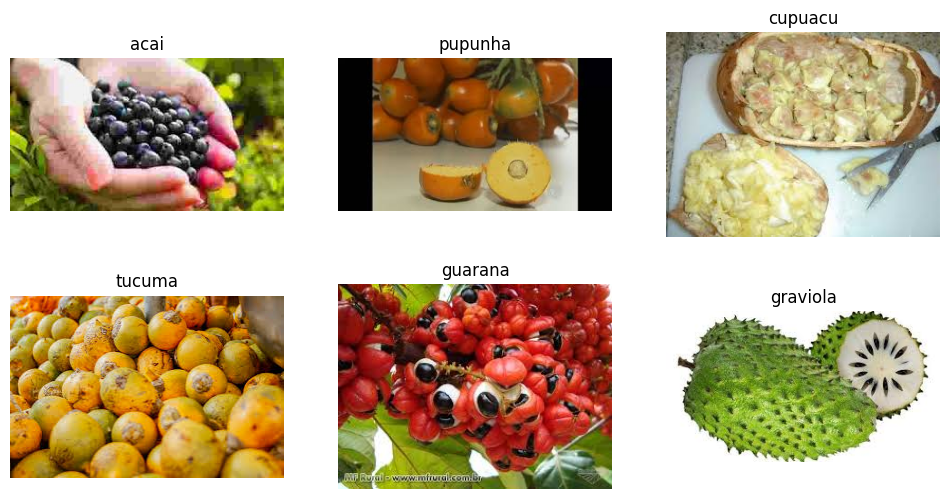

In [3]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

#Check for Corrupted Image:

In [4]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


#Task 2: Loading and Preprocessing Image Data in keras:

In [5]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [8]:
# Load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True, # Shuffle training data
    validation_split=validation_split,
    subset='training', # Specify training subset
    seed=123
)

# Rescale pixel values
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [9]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1655 - loss: 1.9976

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.1623 - loss: 2.0286 - val_accuracy: 0.0000e+00 - val_loss: 1.7342
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.1742 - loss: 1.6713

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step - accuracy: 0.1793 - loss: 1.6672 - val_accuracy: 0.5000 - val_loss: 1.5643
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.4740 - loss: 1.4729

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 873ms/step - accuracy: 0.4805 - loss: 1.4622 - val_accuracy: 0.8333 - val_loss: 1.2270
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step - accuracy: 0.5326 - loss: 1.2857 - val_accuracy: 0.7778 - val_loss: 1.0255
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.5681 - loss: 1.0753 - val_accuracy: 0.8333 - val_loss: 0.6774
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 519ms/step - accuracy: 0.7244 - loss: 0.7961 - val_accuracy: 0.5000 - val_loss: 1.6383
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.7639 - loss: 0.7401 - val_accuracy: 0.8333 - val_loss: 0.4322
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.9301 - loss: 0.4630 - val_accuracy: 0.8333 - val_loss: 0.5200
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 519ms/step - accuracy: 0.9201 - loss: 0.3017 - val_accuracy: 0.7778 - val_loss: 0.7275
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.9410 - loss: 0.2778 - val_accuracy: 0.8333 - val_loss: 0.

In [15]:
# Reload test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5333 - loss: 1.0953
Test Accuracy: 53.33%


In [16]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
              precision    recall  f1-score   support

        acai       0.60      0.60      0.60         5
     pupunha       0.43      0.60      0.50         5
     cupuacu       0.44      0.80      0.57         5
      tucuma       1.00      0.60      0.75         5
     guarana       1.00      0.20      0.33         5
    graviola       0.40      0.40      0.40         5

    accuracy                           0.53        30
   macro avg       0.65      0.53      0.53        30
weighted avg       0.65      0.53      0.53        30



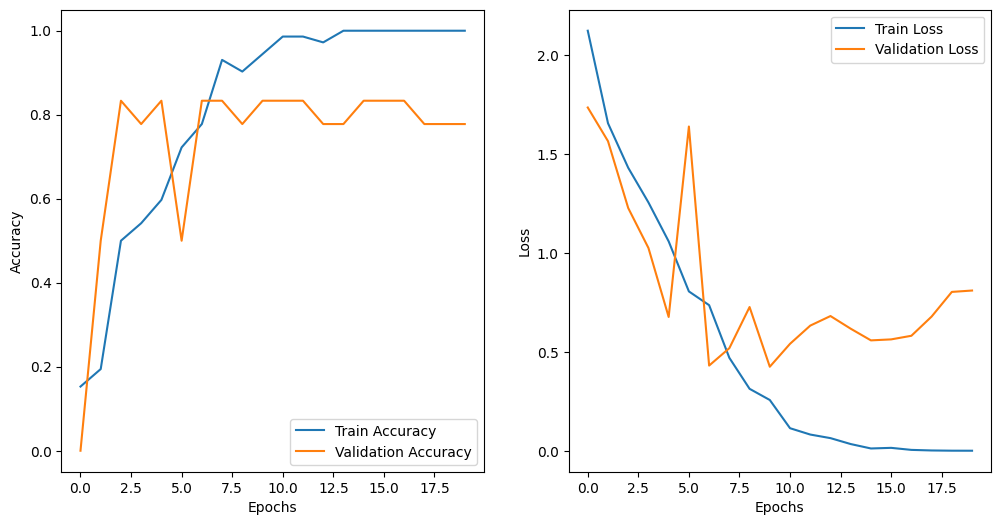

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()